# Homework Assignment 6: Model Evaluation 2
As in the previous assignments, in this homework assignment you will continue your exploration of the [SWAN-SF Dataset](https://doi.org/10.7910/DVN/EBCFKM), described in the paper found [here](https://doi.org/10.1038/s41597-020-0548-x).

This assignment will continue to utilize a copy of the extracted feature dataset we used in Homework 5. Recall that the dataset has been processed by performing log, z-score and range scaling. We continuing to use more than one partition worth of data, so for the scaling, the mean, standard deviation, minimum, and maximum were calculated using data from both partitions so that a global scaling can be performed on each partition. 


---

## Step 1: Downloading the Data

This assignment will continue to use [Partition 1](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/BMXYCB) for a training set and [Partition 2](https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/EBCFKM/TCRPUD) as a testing set. 

---

For this assignment, cleaning, transforming, and normalization of the data has been completed using both partitions to find the various minimum, maximum, standard deviation, and mean values needed to perform these operations. Recall from lecture that we should not perform these operations on each partition individually, but as a whole as there may(will) be different values for these in different partitions. 

For example, if we perform simple range scaling on each partition individually and we see a range of 0 to 100 in one partition and 0 to 10 in another. After individual scaling the values with 100 in the first would be mapped to 1 just like the values that had 10 in the second. This can cause serious performance problems in your model, so I have made sure that the normalization was treated properly for you. 

Below you will find the full partitions and `toy` sampled data from each partition, where only 20 samples from each of our 5 classes have been included in the data.  

#### Full
- [Full Normalized Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/normalized_partition1ExtractedFeatures.csv)
- [Full Normalized Partition 2 feature dataset](http://dmlab.cs.gsu.edu/solar/data/normalized_partition2ExtractedFeatures.csv)

#### Toy
- [Toy Normalized Partition 1 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_normalized_partition1ExtractedFeatures.csv)
- [Toy Normalized Partition 2 feature dataset](http://dmlab.cs.gsu.edu/solar/data/toy_normalized_partition2ExtractedFeatures.csv)

Now that you have the two files, you should load each into a Pandas DataFrame using the [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) method. 

---

### Evaluation Metric

As was done in Homework 5, for each of the models we evaluate in this assignmnet, you will calculate the True Skill Statistic score using the test data from Partition 2 to determine which model performs the best for classifying the positive flaring class.

    True skill statistic (TSS) = TPR + TNR - 1 = TPR - (1-TNR) = TPR - FPR

Where:

    True positive rate (TPR) = TP/(TP+FN) Also known as recall or sensitivity
    True negative rate (TNR) = TN/(TN+FP) Also known as specificity or selectivity
    False positive rate (FPR) = FP/(FP+TN) = (1-TNR) Also known as fall-out or false alarm ratio


**Recall**

    True positive (TP)
    True negative (TN)
    False positive (FP)
    False negative (FN)
    
See [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) for more information.

Below is a function implemented to provide your score for each model.

---

In [1]:
%matplotlib inline
import os
import itertools
import pandas as pd
from pandas import DataFrame 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoLars
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cluster import KMeans

from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def calc_tss(y_true, y_predict):
    '''
    Calculates the true skill score for binary classification based on the output of the confusion
    table function
    
        Parameters:
            y_true   : A vector/list of values that represent the true class label of the data being evaluated.
            y_predict: A vector/list of values that represent the predicted class label for the data being evaluated.
    
        Returns:
            tss_value (float): A floating point value (-1.0,1.0) indicating the TSS of the input data
    '''
    scores = confusion_matrix(y_true, y_predict).ravel()
    TN, FP, FN, TP = scores
    print('TN={0}\tFP={1}\tFN={2}\tTP={3}'.format(TN, FP, FN, TP))
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    
    return tp_rate - fp_rate

---

In addition to the TSS, you will be asked to also calculate the Heidke Skill Score (HSS) to see how much better your model performs than a random forecast.  

Below is a function implemented to provide your score fore each model.

---

In [3]:
def calc_hss(y_true, y_predict):
    '''
    Calculates the Heidke Skill Score for binary classification based on the output of the confusion
    table function.
    
    The HSS measures the fractional improvement of the forecast over the standard forecast.
    The "standard forecast" is usually the number correct by chance or the proportion 
    correct by chance.
    
        Parameters:
            y_true   : A vector/list of values that represent the true class label of the data being evaluated.
            y_predict: A vector/list of values that represent the predicted class label for the data being evaluated.
    
        Returns:
            hss_value (float): A floating point value (-inf,1.0) indicating the HSS of the input data. 
                Negative values indicate that the chance forecast is better, 0 means no skill, and a perfect forecast obtains a HSS of 1.
    '''
    scores = confusion_matrix(y_true, y_predict).ravel()
    TN, FP, FN, TP = scores
    #print('TN={0}\tFP={1}\tFN={2}\tTP={3}'.format(TN, FP, FN, TP))
    P = float(TP + FN)
    N = float(FP + TN)
    numerator = 2*((TP * TN) - (FN * FP))
    denominator = P*(FN + TN) + N*(TP + FP)
    
    return numerator/denominator

---

As in the previous assignment, we will be utilizing a binary classification of our 5 class dataset. So, below is the helper function to change our class labels from the 5 class target feature to the binary target feature. The function is implemented to take a dataframe (e.g. our `abt`) and prepares it for a binary classification by merging the `X`- and `M`-class samples into one group, and the rest (`NF`, `B`, and `C`) into another group, labeled with `1`s and `0`s, respectively.

---

In [4]:
def dichotomize_X_y(data: pd.DataFrame):
    """
    dichotomizes the dataset and split it into the features (X) and the labels (y).
    
    :return: two np.ndarray objects X and y.
    """
    data_dich = data.copy()
    data_dich['lab'] = data_dich['lab'].map({'NF': 0, 'B': 0, 'C': 0, 'M': 1, 'X': 1})
    y = data_dich['lab']
    X = data_dich.drop(['lab'], axis=1)
    return X.values, y.values

---

### Reading the partitions

In [5]:
data_dir = '/Users/carltonbrown/Desktop/FDS/'
#data_file = "partition1/toy_normalized_partition1ExtractedFeatures.csv"
#data_file2 = "Partition 2/toy_normalized_partition2ExtractedFeatures.csv"
data_file = "partition1/normalized_partition1ExtractedFeatures.csv"
data_file2 = "Partition 2/normalized_partition2ExtractedFeatures.csv"

In [6]:
abt = pd.read_csv(os.path.join(data_dir, data_file))
abt2 = pd.read_csv(os.path.join(data_dir, data_file2))


---

### Run Feature Selection

Below you have code to perform feature selction using [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). The scoring function being used is [scikit-learn f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif).

Once feature selection is done with this one method, a set of training and testing dataframes are constructed by doing the following:

* Utilizing the `get_support` function of the feature selection object we get a mask of the features we will select from our original analytics base table DataFrame.  

* The mask of selected features is then paired with the `loc` function on our datframe containing only the descriptive features to get our selected featrues on all rows in our feature dataframe.

* The set of selected features are concatenated with our labels to construct a training dataset.

* This process was then repeated to construct the testing set.

---

In [7]:
numFeat = 20

# Split the target and descriptive features for Partition 1 into two 
# different DataFrame objects
df_labels = abt['lab'].copy()

df_feats = abt.copy().drop(['lab'], axis=1)

# Split the target and descriptive features for Partition 2 inot two
# different DataFrame Objects
df_test_labels = abt2['lab'].copy()
df_test_feats = abt2.copy().drop(['lab'], axis=1)

# Do feature selection
feats1 = SelectKBest(f_classif, k=numFeat).fit(df_feats, df_labels)


In [8]:
# Construct a training dataset from Partition 1 with only the selected descriptive 
# features and the target feature
df_selected_feats1 = df_feats.loc[:, feats1.get_support()]

df_train_set1 = pd.concat([df_labels, df_selected_feats1], axis=1)


# Construct a testing dataset from Partition 2 with only the selected descriptive
# features and the target feature
df_test_selected_feats1 = df_test_feats.loc[:, feats1.get_support()]
df_test_set1 = pd.concat([df_test_labels, df_test_selected_feats1], axis=1)

---
### Q1 (5 points)

Using the feature selection task above as a template, you will now perform feature selection again to produce a second set of training and testing data. This time you will use the [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). 

Instead of using the [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) that is shown in the example documentation linked above, you will be utilizing the [LassoLars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html#sklearn.linear_model.LassoLars) as your `estimator`.  You should also set the `max_features` to the number of features we are going to select (20 features). 

**Note:** The LassoLars class is a regression model and will not work on our string class lables. So, you need to map the `NF`, `B`, `C`, `M`, `X` labels to a range between `-1` and `1` before you attempt to fit the feature selection model to them. You can try evenly spacing them, or forcing the classes that will be used as the negative class into a tight range and those that will be used as the postive class into another tight range.  Maybe this another location for you to do hyperparameter tuning?

In [9]:
numFeat = 20

In [10]:


LL_labels= abt['lab'].map({'NF':0, 'B':0, 'C':0, 'M':1, 'X':1})




LL_feats =abt.drop(['lab'], axis=1)







LL_feats1 = SelectFromModel(estimator=LassoLars(),max_features=numFeat,threshold=-np.inf).fit( LL_feats,LL_labels)


LL_selected_feats1 = LL_feats.loc[:, LL_feats1.get_support()]

LL_train_set1 = pd.concat([abt['lab'], LL_selected_feats1], axis=1,join='inner')


LL_test_labels = abt2['lab'].map({'NF':0, 'B':0, 'C':0, 'M':1, 'X':1})

LL_test_feats = abt2.drop(['lab'], axis =1)



LL_test_selected_feats1 = LL_test_feats.iloc[:, LL_feats1.get_support(indices=True)]

LL_test_set1 = pd.concat([abt2['lab'], LL_test_selected_feats1], axis=1,join='inner') 




---
### Q2 (5 points)

In this question, you will again perform the feature selection task [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). However, this time, you will be utililizing a random forest model called [ExtraTressClssifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) as the `estimator`. 

You need set the `max_features` of the SelectFromModel object to the number of features we are going to select (20 features). 

You also need to set the `n_estimators` of the random forest algorithm to `75` when you construct it.

**Note:** This method allows you to utilize our string class labels, so you don't need to map the lables to any other values. You can use the labels that were used in the original example above.

In [11]:
numFeat = 20

In [12]:


# Split the target and descriptive features for Partition 1 into two 
# different DataFrame objects
ETC_labels = abt['lab'].copy()

ETC_feats = abt.copy().drop(['lab'], axis=1)



# Split the target and descriptive features for Partition 2 inot two
# different DataFrame Objects
ETC_test_labels = abt2['lab'].copy()
ETC_test_feats = abt2.copy().drop(['lab'], axis=1)

# Do feature selection
ETC_feats1 = SelectFromModel(estimator= ExtraTreesClassifier(n_estimators =75),max_features=numFeat).fit(ETC_feats, ETC_labels)

# Construct a training dataset from Partition 1 with only the selected descriptive 
# features and the target feature
#print(ETC_feats1.get_support(indices=True))
ETC_selected_feats1 = ETC_feats.iloc[:, ETC_feats1.get_support(indices=True)]
ETC_train_set1 = pd.concat([ETC_labels, ETC_selected_feats1], axis=1)
#print(ETC_train_set1)



# Construct a testing dataset from Partition 2 with only the selected descriptive
# features and the target feature
ETC_test_selected_feats1 = ETC_test_feats.iloc[:, ETC_feats1.get_support(indices=True)]
ETC_test_set1 = pd.concat([ETC_test_labels, ETC_test_selected_feats1], axis=1)





---
### Q3 (5 points)

Now that you have three different datasets, you need to convert them each to a binary classification problem datase or dichotomize the training and testing data. Lucky for you, a method has already been provided to do this. All you need to do is apply it to teach of the `DataFrame`s you constructed with the feature selected training and testing data from the exmpale, Q1, and Q2.

**Note:** You might want to put the training and testing tuples you get from the call to the dichotomize method into seperate training and testing lists. Then you can loop over them later. 

In [13]:

train_list = []
test_list =[]


train_list.append(dichotomize_X_y(df_train_set1))

train_list.append(dichotomize_X_y(ETC_train_set1))

train_list.append(dichotomize_X_y(LL_train_set1)) 



test_list.append(dichotomize_X_y(df_test_set1))

test_list.append(dichotomize_X_y(ETC_test_set1))

test_list.append(dichotomize_X_y(LL_test_set1))

---
### Q4 (10 points)

Now that you have your data setup, you will be constructing an [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on each one of the different datasets. For this exercise default regularization parameter `C` value of 1.0, the default `kernel` type of `rbf`, and the default setting of the kernel coefficient `gamma` for the `rbf` kernel. You should, however, set the `class_weight` to `balanced` when you construct your models. This way the regularization parameter is adjusted for each class in proportion the occurrence of that class in the dataset.

You should train the model on your training data, then test it on the testing data with the same set of selected descriptive features. You will then calculate both the TSS and HSS scores and print them out.

**Note:** for more information on what the `C` and `gamma` parameters do on the `rbf` kernel see the [RBF SVM parameters](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html) documentation. We won't be tuning these values in this question, but it is genearally accepted that tuning should be done to find the best performing model. 

In [14]:
selected_labels = ['F-Val', 'FromForest','FromLasso']

In [15]:
count = 0
for x,y in zip(train_list, test_list):
 
    print(selected_labels[count])
    count = count+1
    
    model = SVC(class_weight = 'balanced')
    
    model.fit(x[0],x[1])
    predictions = model.predict(y[0])
    
    TSS_score =calc_tss(y[1],predictions)
    print(TSS_score)
    
    CSS_score = calc_hss(y[1],predictions)
    print(CSS_score)
    


F-Val
TN=76129	FP=11027	FN=76	TP=1325
0.8192327710296818
0.1690723900997794
FromForest
TN=84360	FP=2796	FN=572	TP=829
0.5596397923121532
0.3142348954946871
FromLasso
TN=72299	FP=14857	FN=62	TP=1339
0.78528144124744
0.12675478419969763


---
### Q5 (15 points)

After training and testing the SVC model on the above dataset, you will likely see that this process is quite time consuming. This is because the algorithm needs evaluate all the instances in the training dataset to find instances that can be used as points in a separating hyperplane between the samples of different classes.  

In order to speed this process, lets reduce the number of samples in the dataset through undersampling the classes like we did before. Unlike was done before, where we just pick some random sample of instances in the various classes, we will be performing some data informed under sampling using the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) clustering algorithm.

So, what I want you to do is construct a function (I have started it below) that performs the following:

* Groups the data by the `lab` column and finds the size of the smallest group.

* For every group of samples in the dataset that is not the smallest group, you will use the KMeans algorithm to cluster the samples into `K` clusters. The size of `K` is the size of the smallest group.  **Note:** You need to make sure you are only using the descriptive features when doing this, so drop the label column from each group.

* Once you have the `K` clusters, you will get the cluster centers by using the `cluster_centers_` attribute of your Kmeans object. This attribute is a `(n_clusters, n_features)` array of values. These will be the new set of samples of descriptive features for the class you are processing. You should construct a DataFrame with these and add a label column with your class label for each one of these samples.

* The samples for the smalles class group from the original dataset will be the samples you return for that class. 

* You will need to concatenate all of the results into one DataFrame and return it at the end of the function.

Once you have completed the function, you need to apply it to each of your three training sets (the ones that have not had the dicotimize process applied, I hope you kept a copy). Then you will apply the dicotomize process to the sampled training sets and place them into a list for use in the next problem.

**Note:** By training our models on representations of the real data instead of the acutal measurements, we are building a type of surrogate model. By doing so, we can approximate how our model might behave when trained with the true data, but can test several different settings much faster than what we otherwise would.

In [16]:
def perform_under_sample_clust(data:DataFrame)->DataFrame:
    NewDf= data.copy()
    kNewDf=data.copy() 

    
    
    
    
    
    
    minv = min(NewDf['lab'].value_counts())

    group_size =dict(NewDf['lab'].value_counts())
    mingroup=""
    for x in group_size.keys():
  
        if group_size[x] == minv:
            mingroup =x
    NewDf =NewDf.groupby(['lab']).sample(n=minv)
    


    listx = data.columns
    


    for x in set(kNewDf['lab']):
        
        km_df = kNewDf.loc[kNewDf['lab'] == x]
        temp_Df=km_df.drop(['lab'], axis=1)

        kmeans = KMeans(n_clusters=minv).fit(temp_Df)
 
       
        kNewDf = kNewDf[kNewDf['lab'] != x]
        
        
  
        for y in kmeans.cluster_centers_:
            #print(y)
            listr = list(y)
            listr =[x] + listr
           
            kNewDf.loc[kNewDf.index.max() + 1, :] = listr

        

    
    
        
    
                
    NewDf =NewDf.append(kNewDf)

    return NewDf




In [17]:

new_etc_train = perform_under_sample_clust(ETC_train_set1)

new_df_train = perform_under_sample_clust(df_train_set1)
new_ll_train = perform_under_sample_clust(LL_train_set1)

new_etc_test =perform_under_sample_clust(ETC_test_set1 )
new_df_test =perform_under_sample_clust(df_test_set1)
new_ll_test=perform_under_sample_clust(LL_test_set1)

train_list = []
test_list =[]


train_list.append(dichotomize_X_y(new_df_train))
train_list.append(dichotomize_X_y(new_etc_train))
train_list.append(dichotomize_X_y(new_ll_train)) 

test_list.append(dichotomize_X_y(new_df_test))
test_list.append(dichotomize_X_y(new_etc_test))
test_list.append(dichotomize_X_y(new_ll_test))



    #----------------------------------------------

---
### 6 (10 points)

In question 5 we produced datasets that approxumate what our real data looks like. By training our models on these representations of the real data instead of the acutal measurements, we are building a type of surrogate model. In doing so, we can approximate how our model might behave when trained with the true data, but we obtain a major advantage in that we can test several different settings much faster than what we otherwise would if using the true dataset. We can then use these surrogate results to find a range of the hyperparameters that we might wish to investigate using the true input data.

For this question, you will again train your models on the three different feature selected data. However, instead of the full partition 1 training datasets, you will be using the sampling with KMeans training datasets you constructed in Q5. 

You will again be constructing an [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on each one of the different datasets. Like before, you should set the `class_weight` to `balanced` when you construct your models. Unlike the previous question where you traind the models, this time you will be asked to evaluate several different settings for the `kernel`, the regularization parameter `C`, and kernel coefficient `gamma`. **Note:** The `gamma` paramter is only utilized on the ‘rbf’, ‘poly’ and ‘sigmoid’ kernels, so there is no reason to evaluate multiple settings for the `linear` kernel. I have listed the settings of each parameter in a code block below. 

For each of the settings, you should train the model on your training data, then test it on the testing data with the same set of selected descriptive features. You will then calculate both the TSS and HSS scores and print them out.

In [18]:
selected_labels = ['F-Val', 'FromForest', 'FromLasso']

In [19]:
kernel = ['linear', 'poly', 'rbf']
c_vals = [ 0.5, 1.0]
gamma_vals = [0.5, 1, 10]
temp = [kernel, c_vals, gamma_vals]
params = list(itertools.product(*temp))

In [20]:
xcount =0
for x,y in zip(train_list, test_list):
    print(selected_labels[xcount]+"--------------------------")
    xcount =xcount +1
 
    count =0
    for num in range (3):
        if count ==3 :
            count = 0
        print(kernel[num])
        model = SVC(C=c_vals[count] ,kernel=kernel[num] , gamma=gamma_vals[num], class_weight = 'balanced')
        model.fit(x[0],x[1])
        predictions = model.predict(y[0])
        TSS_score =calc_tss(y[1],predictions)
        print(TSS_score)
        CSS_score = calc_hss(y[1],predictions)
        print(CSS_score)
    
     
    


F-Val--------------------------
linear
TN=335	FP=97	FN=35	TP=253
0.6539351851851851
0.6312849162011173
poly
TN=336	FP=96	FN=36	TP=252
0.6527777777777778
0.6308724832214765
rbf
TN=333	FP=99	FN=42	TP=246
0.625
0.6050420168067226
FromForest--------------------------
linear
TN=348	FP=84	FN=35	TP=253
0.6840277777777778
0.6651660101294317
poly
TN=407	FP=25	FN=197	TP=91
0.25810185185185186
0.2866323907455013
rbf
TN=414	FP=18	FN=193	TP=95
0.2881944444444444
0.32066967160334836
FromLasso--------------------------
linear
TN=310	FP=122	FN=28	TP=260
0.6203703703703705
0.5883644346871569
poly
TN=317	FP=115	FN=34	TP=254
0.6157407407407407
0.5881702598120508
rbf
TN=301	FP=131	FN=22	TP=266
0.6203703703703705
0.5835601524224279


---
### 7 (10 points)

Results above were able to find some combinations of hyperparamters and datasets that work fairly well for our problem. But the question remains, can we do better?

Maybe one way to improve our results would be to elinate the easy to classify instances from our dataset and only focus our efforts on the more difficult ones. If you recall from our data preparation there was a feature in our dataset that we could use to easily distinguish between a rather large percentage of `flare` and `non-flare` data. This feature was `R_VALUE_median`, but we don't know what value to use to filter off part of our data.

So, for this question, let's plot and see where a good cutoff might be. To do this, let's use the seaborn [ecdfplot](https://seaborn.pydata.org/generated/seaborn.ecdfplot.html#seaborn.ecdfplot) or the cumulative distribution function plot.  Your input will be the original analytics base table of partition one.  You should set the `x` axis to `R_VALUE_median`, and set the `hue` to `lab`.

After plotting this, you will see that around 0.5 we begin to see some instances of the `M` and around 0.7 we begin to see some instances of the `X` class flares in our dataset. So, use 0.5 as a threshold value to filter out all of the instances that fall below this threshold from our training data. Construct a copy of the original partition 1 data with this applied.

You can then verify this using the seaborn [kdeplot](https://seaborn.pydata.org/generated/seaborn.kdeplot.html#seaborn.kdeplot) using the new filtered data as input, setting `x` to `R_VALUE_median` again, and setting `hue` to `lab` again.  

<AxesSubplot:xlabel='R_VALUE_median', ylabel='Proportion'>

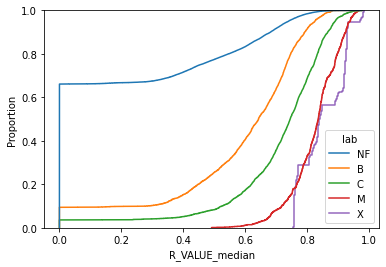

In [21]:
sns.ecdfplot(data=abt, x="R_VALUE_median",hue='lab')


<AxesSubplot:xlabel='R_VALUE_median', ylabel='Density'>

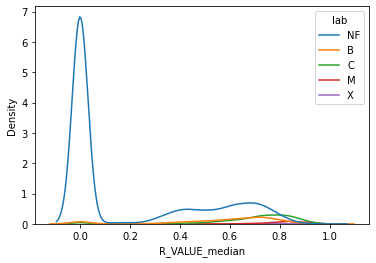

In [22]:
sns.kdeplot(data=abt,x="R_VALUE_median",hue='lab')

<AxesSubplot:xlabel='R_VALUE_median', ylabel='Proportion'>

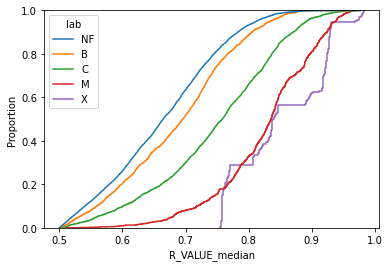

In [23]:
filt_NewDf = abt[abt['R_VALUE_median'] >.5].copy()
sns.ecdfplot(data=filt_NewDf , x="R_VALUE_median",hue='lab')

<AxesSubplot:xlabel='R_VALUE_median', ylabel='Density'>

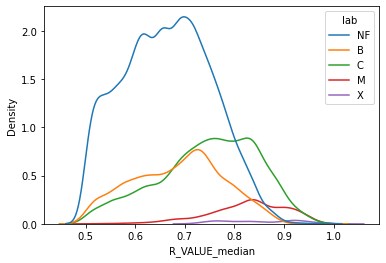

In [24]:

sns.kdeplot(data=filt_NewDf,x="R_VALUE_median",hue='lab')

---
### 8 (10 points)

For this question, you will utilize the filtered analytics base table you constructed in the previous question.  You should:

* Repeat the feature selection I did for you in the  example using the [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), and scoring function [scikit-learn f_classif](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif).

* Repeat the feature selection from Q1 using the [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection), and utilizing the [LassoLars](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html#sklearn.linear_model.LassoLars) as your `estimator`.  You should also set the `max_features` to the number of features we are going to select (20 features).

* Repeat the feature selection from Q2 using [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel) class from [scikit-learn Univariate Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). With a random forest model called [ExtraTressClssifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier) as the `estimator`. The `n_estimators` of the random forest algorithm should be set to `75` when you construct it. The `max_features` of the SelectFromModel should be set to the number of features we are going to select (20 features).

In [25]:
filt_NewDf

numFeat = 20

# Split the target and descriptive features for Partition 1 into two 
# different DataFrame objects
df_labels = filt_NewDf['lab'].copy()

df_feats = filt_NewDf.copy().drop(['lab'], axis=1)

# Split the target and descriptive features for Partition 2 inot two
# different DataFrame Objects
df_test_labels = abt2['lab'].copy()
df_test_feats = abt2.copy().drop(['lab'], axis=1)

# Do feature selection
feats1 = SelectKBest(f_classif, k=numFeat).fit(df_feats, df_labels)

# Construct a training dataset from Partition 1 with only the selected descriptive 
# features and the target feature
df_selected_feats1 = df_feats.loc[:, feats1.get_support()]

df_train_set1 = pd.concat([df_labels, df_selected_feats1], axis=1)


# Construct a testing dataset from Partition 2 with only the selected descriptive
# features and the target feature
df_test_selected_feats1 = df_test_feats.loc[:, feats1.get_support()]
df_test_set1 = pd.concat([df_test_labels, df_test_selected_feats1], axis=1)


#----------------------------------------------
    # TODO: Complete here.
    #----------------------------------------------
    

#print(LL_test_set1)





LL_labels= filt_NewDf['lab'].map({'NF':0, 'B':0, 'C':0, 'M':1, 'X':1})




LL_feats =filt_NewDf.drop(['lab'], axis=1)







LL_feats1 = SelectFromModel(estimator=LassoLars(),max_features=numFeat,threshold=-np.inf).fit( LL_feats,LL_labels)
#print(LL_feats1.get_support())



LL_selected_feats1 = LL_feats.loc[:, LL_feats1.get_support()]
#LL_selected_feats1.replace([np.inf, -np.inf,np.nan], .1, inplace=True)
LL_train_set1 = pd.concat([abt['lab'], LL_selected_feats1], axis=1,join='inner')


LL_test_labels = abt2['lab'].map({'NF':0, 'B':0, 'C':0, 'M':1, 'X':1})

LL_test_feats = abt2.drop(['lab'], axis =1)



LL_test_selected_feats1 = LL_test_feats.iloc[:, LL_feats1.get_support(indices=True)]
#lasso_test =  LL_feats.loc[:, LL_feats1.get_support()]

LL_test_set1 = pd.concat([abt2['lab'], LL_test_selected_feats1], axis=1,join='inner') 




    
#--------

# Split the target and descriptive features for Partition 1 into two 
# different DataFrame objects
ETC_labels = filt_NewDf['lab'].copy()

ETC_feats = filt_NewDf.copy().drop(['lab'], axis=1)



# Split the target and descriptive features for Partition 2 inot two
# different DataFrame Objects
ETC_test_labels = abt2['lab'].copy()
ETC_test_feats = abt2.copy().drop(['lab'], axis=1)

# Do feature selection
ETC_feats1 = SelectFromModel(estimator= ExtraTreesClassifier(n_estimators =75),max_features=numFeat).fit(ETC_feats, ETC_labels)

# Construct a training dataset from Partition 1 with only the selected descriptive 
# features and the target feature

ETC_selected_feats1 = ETC_feats.iloc[:, ETC_feats1.get_support(indices=True)]
ETC_train_set1 = pd.concat([ETC_labels, ETC_selected_feats1], axis=1)




# Construct a testing dataset from Partition 2 with only the selected descriptive
# features and the target feature
ETC_test_selected_feats1 = ETC_test_feats.iloc[:, ETC_feats1.get_support(indices=True)]
ETC_test_set1 = pd.concat([ETC_test_labels, ETC_test_selected_feats1], axis=1)




---
### Q9 (10 points)

Using the training and testing datsets you constructed in the previous question after performing feature selection on the filtered partition 1 analytics base table. You now need to perform the sampling on the training data using the function you made in Q5.

Then you should convert each of the new training and testing datasets to a binary classification problem datase or dichotomize the training and testing data like you did in Q3. Lucky for you, a method has already been provided to do this. All you need to do is apply it to teach of the `DataFrame`s you constructed with the feature selected training and testing data.

**Note:** You might want to put the training and testing tuples you get from the call to the dichotomize method into seperate training and testing lists. Then you can loop over them later. 


In [26]:
new_etc_train = perform_under_sample_clust(ETC_train_set1)
new_df_train = perform_under_sample_clust(df_train_set1)
new_ll_train = perform_under_sample_clust(LL_train_set1)

new_etc_test =perform_under_sample_clust(ETC_test_set1 )
new_df_test =perform_under_sample_clust(df_test_set1)
new_ll_test=perform_under_sample_clust(LL_test_set1)

train_list = []
test_list =[]


train_list.append(dichotomize_X_y(new_df_train))
train_list.append(dichotomize_X_y(new_ll_train))

train_list.append(dichotomize_X_y(new_etc_train))

test_list.append(dichotomize_X_y(new_df_test))
test_list.append(dichotomize_X_y(new_ll_test))


test_list.append(dichotomize_X_y(new_etc_test))





---
### Q10 (20 points)

Like in Q6, this question will be utilizing the filtered and sampled datasets constructed in the previous question. For this question, you will again train your models on the three different feature selected data that had the instances below our thrshold filtered out and then had sampling by clustering performed on them. 

You will again be constructing an [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) model on each one of the different datasets. Like before, you should set the `class_weight` to `balanced` when you construct your models. You will again evaluate several different settings for the `kernel`, the regularization parameter `C`, and kernel coefficient `gamma`. **Note:** The `gamma` paramter is only utilized on the ‘rbf’, ‘poly’ and ‘sigmoid’ kernels, so there is no reason to evaluate multiple settings for the `linear` kernel. I have listed the settings of each parameter in a code block below. 

For each of the settings, you should train the model on your training data, then test it on the testing data with the same set of selected descriptive features. You will then calculate both the TSS and HSS scores and print them out. **Note:** The testing data has the samples in it that are below our threshold value, so you will first need to filter those out of the data you plan to pass to your model for testing. However, you still want those instances included in the calculation of the TSS and HSSS. So, your groud truth `lab` data should include all the instances in partition 2. You will need to concatenate a vector with all zeros in it to the match the labels you partitioned from the model testing data. 

Let's give you a representation of that:
    
    labels_from_data = [labels for samples > threshold] + [labels for samples <= threshold]
    predict_labels = [labels from the model on > thrshold samples] + [0s the length of samples <= threshold]



In [27]:
thresh = 0.5
selected_labels = ['F-Val', 'FromForest', 'FromLasso']
kernel = ['linear', 'poly', 'rbf']
c_vals = [ 0.5, 1.0]
gamma_vals = [0.5, 1, 10]
temp = [kernel, c_vals, gamma_vals]
params = list(itertools.product(*temp))

In [28]:

xcount = 0
for x,y in zip(train_list, test_list):
    print(selected_labels[xcount]+"--------------------------")
    xcount =xcount +1
    
    #print(x[0])
    #print(y)
    count =0
    for num in range (3):
        if count ==3 :
            count = 0
        print(kernel[num])
        model = SVC(C=c_vals[count] ,kernel=kernel[num] , gamma=gamma_vals[num], class_weight = 'balanced')
        model.fit(x[0],x[1])
        predictions = model.predict(y[0])
        TSS_score =calc_tss(y[1],predictions)
        print(TSS_score)
        CSS_score = calc_hss(y[1],predictions)
        print(CSS_score)
    


F-Val--------------------------
linear
TN=346	FP=86	FN=34	TP=254
0.6828703703703703
0.6629213483146067
poly
TN=359	FP=73	FN=85	TP=203
0.5358796296296297
0.5396270396270396
rbf
TN=340	FP=92	FN=42	TP=246
0.6412037037037037
0.6231721034870641
FromForest--------------------------
linear
TN=345	FP=87	FN=35	TP=253
0.6770833333333333
0.6573033707865169
poly
TN=348	FP=84	FN=41	TP=247
0.6631944444444444
0.6470920383963862
rbf
TN=330	FP=102	FN=28	TP=260
0.6666666666666667
0.6392896781354052
FromLasso--------------------------
linear
TN=389	FP=43	FN=65	TP=223
0.6747685185185186
0.6834701055099648
poly
TN=405	FP=27	FN=222	TP=66
0.16666666666666666
0.18786692759295498
rbf
TN=400	FP=32	FN=142	TP=146
0.43287037037037035
0.4622991347342398


All of these results are getting unruely, we should maybe be saving them to do analysis on them too? Maybe I'll ask you to do that for the extra credit assignment.